Soft Independent Modeling of Class Analogies (SIMCA)
===

Author: Nathan A. Mahynski

Date: 2023/09/12

Description: Derivation and examples of [SIMCA](https://en.wikipedia.org/wiki/Soft_independent_modelling_of_class_analogies).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/gallery/simca.ipynb)

Soft Independent Modelling of Class Analogies (SIMCA) is a popular method for building authentication models.  Like Soft PLS-DA, it can determine if a new sample is consistent with a training set of known authentic class examples.  However, unlike PLS-DA, SIMCA models are trained on a single class and return a binary True/False prediction as to whether a new sample is consistent with previously seen ones.  There have been many variations on the technique since its [introduction by Wold](https://www.sciencedirect.com/science/article/abs/pii/0031320376900145) in the late 1970s.  We will review 2 different approaches: one more conventional, another which is more modern.

Furthermore, there are differences in the way each model may be optimized. "Rigorous" models use only examples of the target class and are designed to reach a certain sensitivity (specificity cannot be evaluated); "compliant" models are instead trained using alternative examples to reach an overall ideal balance of specificity and sensitivity.  While the latter often appear to perform "better," the results are biased based on what alternatives are available for training which is difficult to fully quantify. See [Rodionova et al.](https://www.sciencedirect.com/science/article/pii/S0169743916302799) for more discussion.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [2]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [3]:
import scipy
import sklearn

import numpy as np

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

from pychemauth.classifier.simca import SIMCA_Model, DDSIMCA_Model
from pychemauth.preprocessing.scaling import CorrectedScaler

In [4]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

json      : 2.0.9
matplotlib: 3.7.2
watermark : 2.4.3
numpy     : 1.24.3
pychemauth: 0.0.0b3
sklearn   : 1.3.0
scipy     : 1.11.1



A Conventional Implementation
---

See ["Robust classification in high dimensions based on the SIMCA Method," Vanden Branden, Hubert, Chemometrics and Intelligent Laboratory Systems 79 (2005) 10-21.](https://doi.org/10.1016/j.chemolab.2005.03.002) and ["Decision criteria for soft independent modelling of class analogy applied to near infrared data" De Maesschalk et al., Chemometrics and Intelligent Laboratory Systems 47 (1999) 65-77.](https://doi.org/10.1016/S0169-7439(98)00159-2) for details and justification of this implementation.

Step 1: The raw data is **broken up by group (supervised)**; then **for each group** a PCA model for the data is constructed as follows:
    
$$
X = TP^T + E.
$$

Here, $X$, is the training data and has dimensions NxJ where $T$ is the scores matrix (projection of $X$ into some space, NxK), determined by $P$ which is related to the loading matrix (JxK), and $E$ as the error or residual matrix.  $E$ may be explicitly calculated by $E = X - TP^T$. $X$ should be centered, and possibly scaled, as is required for PCA.

<!-- As in PLS-DA, or other discriminant methods, a hard boundary between classes can be defined by drawing a hyperplane that divides them.  This leads to a hard "yes" or "no" if a point belongs to a certain class, and it can only belong to a single class.  Methods like SIMCA can predict if a point belongs to class A, class B, both, or neither.  It does this by defining a model boundary (distance from class centroid, for example) which envelops samples from class A; boundaries around different classes can be disjoint or overlapping, and their union does not need to entirely fill space (so that some points could belong to no classes).  Note the similarity to [Soft PLS-DA](plsda.ipynb); however, PLS-DA is trained with a fixed number of classes, whereas each SIMCA model is trained on only a single one. -->

Step 2: The residual standard deviation (RSD) values are calculated for the test set and training set a little differently.  For a given observation in the test set:

$$
RSD_{i, test}^2 = \frac{e_i^Te_i}{J-K},
$$

while for the training set (composed of the I samples) the degrees of freedom are modified slightly:

$$
RSD_{train}^2 = \frac{\sum_{i,train} e_i^Te_i}{(J-K)(N-K-1)}.
$$

Here, $e_i^Te_i$ is referred to as the squared orthogonal distance, $OD^2$. 

Step 3: The threshold for the model is given by:

$$
F_i = \frac{RSD_{i, test}^2}{RSD_{\rm train}^2}
$$

where the $F$ value is compared to some critical limiting value taken at a given significance, for example, $F_{\rm crit} = F_{(J-K),(N-K-1);0.95}$ is commonly used as a 95% quantile limit.  If $F_i/F_{\rm crit} < 1$, we assign the observation to the class.

Note that the number of principal components, K, does NOT need to the same from group to group; in fact, this is where the "independent" part of S(I)MCA comes from. (see Vanden Branden et al.)

Note: there is apparently some discrepancy, historically, on what degrees of freedom to use when computing these F statistics.  In De Maesschalk et al. Chem. Intell. Lab. Sys. 47 (1999) the authors discuss this in detail; essentially, in the above equations the term (J - K) is only valid when N > J (more samples than variables).  Otherwise, then term should be replaced with ((N - 1) - K) in both the test and train cases (and for computing the critical F value); i.e., use the smaller of (N,J), but due to mean centering we lose 1 DoF from I.  However, this term cancels out when computing the f value for a given sample.  It does, however, **affect the calculation of the critical F value**.  From a statistics perspective this is important so that $\alpha$ is meaningful; from a machine learning perspective, if we simply chose to optimize $\alpha$ to balance sensitivity and specificity of a model, then it is effectively irrelevant since this procedure treats $F_{\rm crit}$ as an adjustable parameter.

In [5]:
class SIMCA:
    def __init__(self, n_components, alpha=0.05):
        self.__n_components = n_components
        self.__alpha = alpha

    def fit(self, X_train):
        # 1. Autoscale X
        self.__ss = CorrectedScaler(with_mean=True, with_std=True)
        self.__X_train = X_train.copy()

        # 2. Perform PCA on standardized coordinates
        self.__pca = PCA(n_components=self.__n_components, random_state=0)
        self.__pca.fit(self.__ss.fit_transform(self.__X_train))

        # 3. Compute critical F value
        self.__N = X_train.shape[0]
        self.__J = X_train.shape[1]
        self.__K = self.__n_components
        self.__a = self.__J if self.__N > self.__J else self.__N-1
        
        self.__f_crit = scipy.stats.f.ppf(
            1.0-self.__alpha,
            (self.__a-self.__K),
            (self.__a-self.__K)*(self.__N-self.__K-1)
        )

    def predict(self, X):
        # Check that observations are rows of X
        X = np.array(X)
        if len(X.shape) == 1:
            X = X.reshape(-1,1)
        assert(X.shape[1] == self.__J)

        """
        From "Multivariate class modeling for the verification of food-authenticity
        claims," Oliveri and Downey, TrAC 35 (2012):
        
        "The distances between each sample and the model are
        evaluated in the full multidimensional space, which is
        also defined by the non-significant PCs (SIMCA outer
        space). This permits the inclusion of information on
        random distribution of samples around the model, which
        arises from non-significant, and therefore uninformative,
        variations.""
        """
        
        # Following Vanden Branden et al.
        X_pred = self.__ss.inverse_transform(
            self.__pca.inverse_transform(
                self.__pca.transform(
                    self.__ss.transform(X)
                )
            )
        )
        numer = np.sum((X - X_pred)**2, axis=1)/(self.__a - self.__K)

        X_pred = self.__ss.inverse_transform(
            self.__pca.inverse_transform(
                self.__pca.transform(
                    self.__ss.transform(self.__X_train)
                )
            )
        )

        OD2 = np.sum((self.__X_train - X_pred)**2, axis=1)
        denom = np.sum(OD2) / ((self.__a - self.__K)*(self.__N - self.__K - 1))

        # F-test for each distance
        F = numer/denom

        # If f < f_crit, it belongs to the class
        return F < self.__f_crit

In [6]:
X, Y = sklearn.datasets.make_blobs(
    n_samples=100,
    n_features=5,
    centers=3,
    cluster_std=3,
    shuffle=True,
    random_state=0
)

X_train, y_train = X[:80], Y[:80]
X_test, y_test = X[80:], Y[80:]

In [7]:
# We need a new SIMCA object for EACH training class - each one indicates whether we predict a point
# belongs to that class or not.
manual_simca_model = {}
for i in range(3):
    manual_simca_model[i] = SIMCA(n_components=1, alpha=0.05)
    manual_simca_model[i].fit(X_train[y_train == i])

In [8]:
manual_simca_model[0].predict(X_test) == (y_test == 0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [9]:
# PyChemAuth provides a more versatile class for this.
pychemauth_simca_model = {}
for i in range(3):
    pychemauth_simca_model[i] = SIMCA_Model(n_components=1, alpha=0.05, scale_x=True)
    pychemauth_simca_model[i].fit(X_train[y_train == i])

In [10]:
pychemauth_simca_model[0].predict(X_test) == (y_test == 0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [11]:
for i in [0, 1, 2]:
    assert np.all(pychemauth_simca_model[i].predict(X_test) == manual_simca_model[i].predict(X_test))

Note: To use [SIMCA in pipelines](simca_example.ipynb), etc. pychemauth provides a `SIMCA_Authenticator` wrapper class that should be used instead of this.

A Modern Approach: DD-SIMCA
---

A more modern incarnation of SIMCA is data-driven SIMCA or DD-SIMCA.  There are several descriptions of the technique:

1. ["Acceptance areas for multivariate classification derived by projection methods," Pomerantsev, A., Journal of Chemometrics 22 (2008) 601-609.](https://doi.org/10.1002/cem.1147)

2. ["Concept and role of extreme objects in PCA/SIMCA," Pomerantsev, A. and Rodionova, O., Journal of Chemometrics 28 (2014) 429-438.](https://doi.org/10.1002/cem.2506)

3. ["Detection of outliers in projection-based modeling," Rodionova, O., and Pomerantsev, A., Anal. Chem. 92 (2020) 2656-2664.](https://doi.org/10.1021/acs.analchem.9b04611)

Briefly, the idea is to use not only the outer distance based on the error, but also an "inner distance" or "score distance" based on the distance a point is from the class center in the class subspace.  

Step 1: The raw data is **broken up by group (supervised)**; then **for each group** a PCA model for the data is constructed as follows:
    
$$
X = TP^T + E.
$$

Here, $X$, is the training data and has dimensions NxJ where $T$ is the scores matrix (projection of $X$ into some space, NxK, determined by), $P$ is related to the loading matrix (JxK), and $E$ as the error or residual matrix.  $E$ may be explicitly calculated by $E = X - TP^T$. $X$ should be centered, and possibly scaled, as is required for PCA.

Step 2: Compute the OD (square), q, and SD (squared), h, for each point where each are defined as:

$$h_i = \sum_{j=1}^K \frac{t_{i,j}^2}{\lambda_j}$$

$$q_i = \sum_{j=1}^K e_{i,j}^2.$$

Step 3: Compute the critical distance for class membership. It has been shown by [Pomerantsev](https://onlinelibrary.wiley.com/doi/pdf/10.1002/cem.1147?casa_token=0NaS1t1S6mYAAAAA:VHFiiSku72EY2KXifPJtZhwXlX8PhwGPDPKUN5LvBnhB2sSTe315Uc7vlX7GmuIlgPJTNIr8chd8JA) that both the SD and OD can be well approximated by scaled chi-squared distributions.  Thus, a critical distance can be defined by a linear combination:

$$
c = N_h \frac{h}{h_0} + N_q \frac{q}{q_0} \sim \chi^2(N_h+N_q)
$$

Here, $N_h$ and $N_q$ are degrees of freedom, and $h_0$ and $q_0$ are scaling factors.  These can be estimated in a [data-driven way](https://doi.org/10.1002/cem.2506), i.e., estimated from the training set rather than fixed based on the size of the set, hence the name "DD-SIMCA."  Methods of estimation are discussed in Ref. [2].  The final decision rule for a class is $c < c_{\rm crit}$ with $c_{\rm crit} = \chi^{-2}(1-\alpha, N_h+N_q)$.

It is possible to use a combination of OD and SD in other ways.  See ["Class-modelling in food analytical chemistry: Development, sampling, optimisation and validation issues – A tutorial," Oliveri Analytical Chimica Acta 982 (2017)](https://www.sciencedirect.com/science/article/pii/S0003267017306050) and ["Robust classification in high dimensions based on the SIMCA Method," Vanden Branden, Hubert, Chemometrics and Intelligent Laboratory Systems 79 (2005) 10-21](https://doi.org/10.1016/j.chemolab.2005.03.002). Pomerantsev discusses advantages and disadvantages of 5 different metrics involving SD and OD in Ref. [1]. They conclude the above approach is the best.

In [12]:
class DD_SIMCA:
    def __init__(self, n_components, alpha=0.05):
        self.__n_components = n_components
        self.__alpha = alpha

    def fit(self, X_train):
        # 1. Autoscale X
        self.__ss = CorrectedScaler(with_mean=True, with_std=True)
        self.__X_train = X_train.copy()

        # 2. Perform PCA on standardized coordinates
        self.__pca = PCA(n_components=self.__n_components)
        self.__pca.fit(self.__ss.fit_transform(self.__X_train))

        # 3. Compute critical distance
        self.__J = X_train.shape[1]
        
        # Compute OD (q) and SD (h)
        h_vals, q_vals = self.h_q(self.__X_train)
        
        # These are not robust estimates - pychemauth provides a more robust implementation
        # but for this example we will use a simple estimate.
        def dof(u0, u_vals):
            return int(np.max([round(2.0 * u0**2 / np.std(u_vals, ddof=1) ** 2, 0), 1]))
        self.__h0, self.__q0 = np.mean(h_vals), np.mean(q_vals)
        self.__Nh, self.__Nq = dof(self.__h0, h_vals), dof(self.__q0, q_vals)

        self.__c_crit = scipy.stats.chi2.ppf(1.0 - self.__alpha, self.__Nh + self.__Nq)

    def h_q(self, X):
        X_std = self.__ss.transform(X)
        T = self.__pca.transform(X_std)
        X_pred = self.__pca.inverse_transform(T)

        # OD - this is to produce identical results to mdatools (https://mdatools.com/docs/)
        q_vals = np.sum((X_std - X_pred)**2, axis=1)

        # SD
        h_vals = np.sum(T**2/self.__pca.explained_variance_, axis=1)

        return h_vals, q_vals


    def distance(self, X):
        h, q = self.h_q(X)

        return self.__Nh*h/self.__h0 + self.__Nq*q/self.__q0

    def predict(self, X):
        X = np.array(X)
        if len(X.shape) == 1:
            X = X.reshape(-1,1)
        assert(X.shape[1] == self.__J)

        # If c < c_crit, it belongs to the class
        return self.distance(X) < self.__c_crit

In [13]:
X, Y = sklearn.datasets.make_blobs(
    n_samples=100,
    n_features=5,
    centers=3,
    cluster_std=3,
    shuffle=True,
    random_state=0
)

X_train, y_train = X[:80], Y[:80]
X_test, y_test = X[80:], Y[80:]

In [14]:
# We need a new SIMCA object for EACH training class - each one indicates whether we predict a point
# belongs to that class or not.
manual_ddsimca_model = {}
for i in range(3):
    manual_ddsimca_model[i] = DD_SIMCA(n_components=1, alpha=0.05)
    manual_ddsimca_model[i].fit(X_train[y_train == i])

In [15]:
manual_ddsimca_model[0].predict(X_test) == (y_test == 0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [16]:
# PyChemAuth provides a more versatile class for this.
pychemauth_ddsimca_model = {}
for i in range(3):
    pychemauth_ddsimca_model[i] = DDSIMCA_Model(n_components=1, alpha=0.05, scale_x=True, robust=None)
    pychemauth_ddsimca_model[i].fit(X_train[y_train == i])

In [17]:
h, q = pychemauth_ddsimca_model[0]._h_q(X_test) 

In [18]:
h 

array([9.34338240e-01, 9.25700723e-02, 5.99724281e-02, 2.14459274e-03,
       8.34333673e-03, 5.56935710e-01, 1.07262602e+00, 9.48696596e-05,
       7.65728807e+00, 1.14343225e+01, 2.63242230e-01, 1.93758287e-01,
       1.26444253e+00, 2.70389654e+00, 3.55099973e+00, 1.43971452e-01,
       2.34807602e+00, 1.06274050e+00, 8.87320413e-01, 5.78675350e+00])

In [19]:
q 

array([ 3.92193144,  5.87194037, 13.79354282,  4.11393526,  0.16968608,
        1.55054305, 11.28924556, 20.42144643, 20.48369521, 21.06689766,
        3.48130805, 22.9100697 ,  3.70056302, 11.72848316,  0.56888214,
        4.52800812, 19.73879826, 14.08465199, 16.00852886, 31.45140373])

In [20]:
h_, q_ = manual_ddsimca_model[0].h_q(X_test)
assert np.allclose(
    h_ / manual_ddsimca_model[0]._DD_SIMCA__h0,
    h / pychemauth_ddsimca_model[0]._DDSIMCA_Model__h0_
)
assert np.allclose(
    q_ / manual_ddsimca_model[0]._DD_SIMCA__q0,
    q / pychemauth_ddsimca_model[0]._DDSIMCA_Model__q0_
)

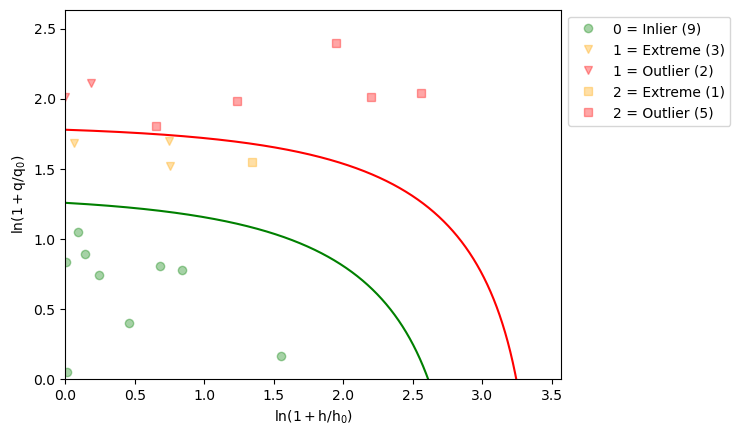

In [21]:
# pychemauth has convenient visualization tools to see which points are considered consistent with the class (inside
# green boundary) and which are not.

# Here, all 9 examples of class 0 are considered authentic, while all other classes are rejected.
_ = pychemauth_ddsimca_model[0].visualize(X_test, y_test)

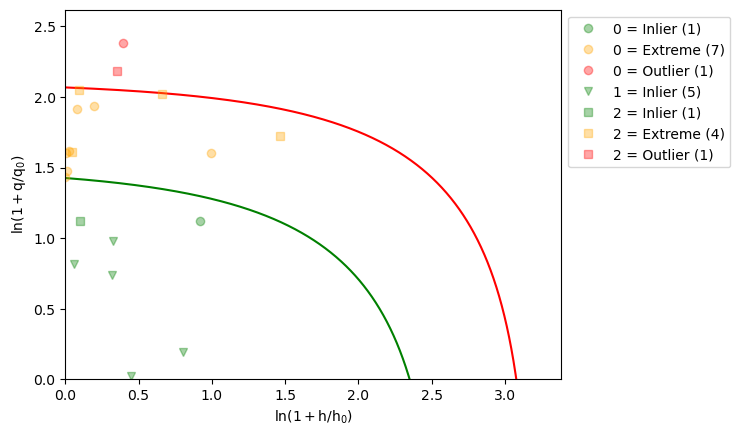

In [22]:
# Here, 1 example of class 0 and 1 example of class 2 are considered (incorrectly) to be consistent with class 1,
# though all 5 examples of class 1 are properly determined to be authentic.
_ = pychemauth_ddsimca_model[1].visualize(X_test, y_test)

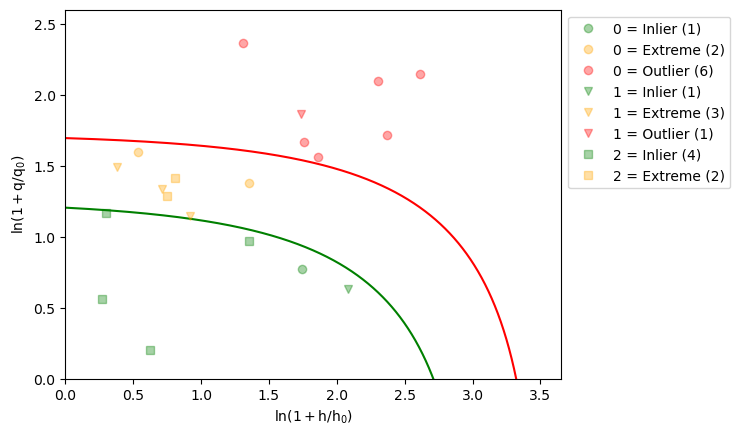

In [23]:
# Again, 1 example from the other 2 classes are incorrectly deemed authentic examples of class 2, and 2 authentic examples
# of class 2 are (incorrectly) rejected.
_ = pychemauth_ddsimca_model[2].visualize(X_test, y_test)